In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from correlation_estimators import calculate_pearson
from sampling import pps, accept_reject
from scipy.stats.distributions import norm

PROPERTY = 'fire_size'

df = pd.read_csv('./data/FW_Veg_Rem_Combined.csv')
to_drop = ['longitude', 'Vegetation', 'latitude', 'Temp_pre_30', 'Temp_cont', 'Wind_pre_30', 'Wind_cont', 'fire_size_class',
'fire_name', 'putout_time', 'disc_pre_year', 'fire_mag', 'Temp_pre_15', 'Wind_pre_15',
'Hum_pre_30', 'Hum_pre_15', 'Hum_cont', 'Prec_pre_30', 'Prec_pre_15', 'Prec_cont']
df.drop(labels=to_drop, axis='columns', inplace=True)

params_norm = norm.fit(df[PROPERTY])

df_pps = pps(df, PROPERTY, 0.1)
df_ar = accept_reject(df, PROPERTY, norm, 15)

sns.displot(data=df_pps, x=PROPERTY,  bins=50, stat='probability')
plt.title('Fire size using PPS sampling')
plt.show()

sns.displot(data=df_ar, x=PROPERTY,  bins=50, stat='probability')
plt.title('Fire size using accept-reject sampling')
plt.show()

SyntaxError: invalid syntax (sampling.py, line 71)

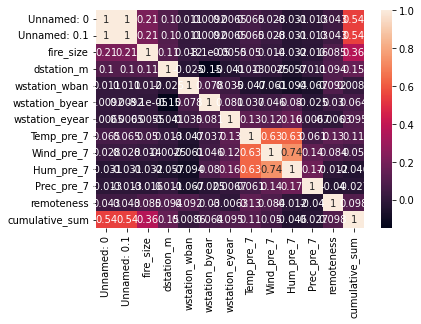

In [ ]:
#correcaltion matrix

corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [ ]:
PREDICTORS = ['remoteness', 'Temp_pre_7', 'Hum_pre_7', 'Wind_pre_7', 'Prec_pre_7']

for pred in PREDICTORS:
    per_pps = calculate_pearson(df_pps, pred, PROPERTY)
    per_ar = calculate_pearson(df_ar, pred, PROPERTY)

    print(f'Pearsons coefficient between fire size and {pred} for pps is {per_pps}, whereas for AR {per_ar}')


Pearsons coefficient between fire size and remoteness for pps is 0.09633397717480195, whereas for AR 0.11926495394231706
Pearsons coefficient between fire size and Temp_pre_7 for pps is 0.029993131967164934, whereas for AR -0.16331283579321443
Pearsons coefficient between fire size and Hum_pre_7 for pps is -0.036852450427315414, whereas for AR -0.033529668445651
Pearsons coefficient between fire size and Wind_pre_7 for pps is -0.011235385317008535, whereas for AR -0.1161374244775544
Pearsons coefficient between fire size and Prec_pre_7 for pps is -0.02141726855839599, whereas for AR 0.3173747749930411


In [ ]:
#BAsesian network